In [1]:
import os
from io import open
import glob
import unicodedata
import string

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

In [54]:
def findFiles(path): return glob.glob(path)
all_letters = string.ascii_letters + ".,;-"
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.replace('\\', '/').split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_letters = len(all_letters)
n_categories = len(all_categories)

n_letters, n_categories

(56, 18)

In [55]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J').size())
print(lineToTensor('Jones').size())

torch.Size([1, 56])
torch.Size([5, 1, 56])


In [56]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [57]:
# input_size, hidden_size, num_layers
input_size = 10 # num_features
hidden_size = 20 # cell size
num_layers = 2
batch_size = 3
seq_len = 5

gru = nn.GRU(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, hn = gru(input, h0)

In [58]:
lstm = nn.LSTM(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
c0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, (hn, cn) = lstm(input, (h0, c0))

In [76]:
import numpy as np
import pandas as pd

In [60]:
df = pd.DataFrame()
df['word'] = [w for cat in all_categories for w in category_lines[cat]]
df['target'] = [cat for cat in all_categories for w in category_lines[cat]]

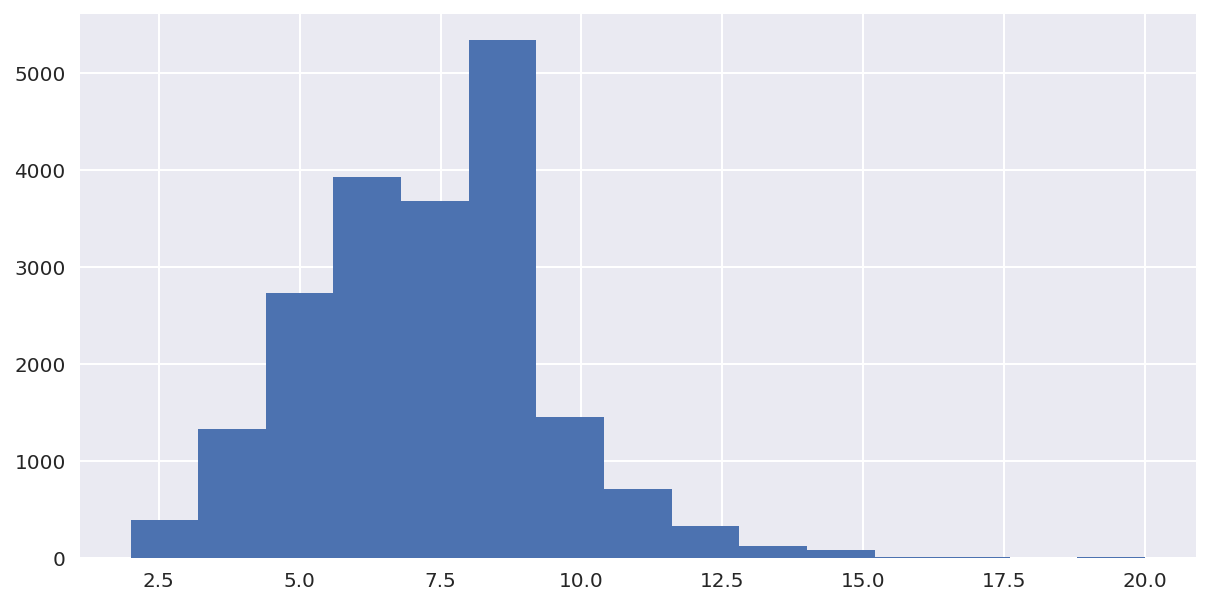

In [61]:
df.word.apply(len).hist(bins=15, figsize=(10,5))

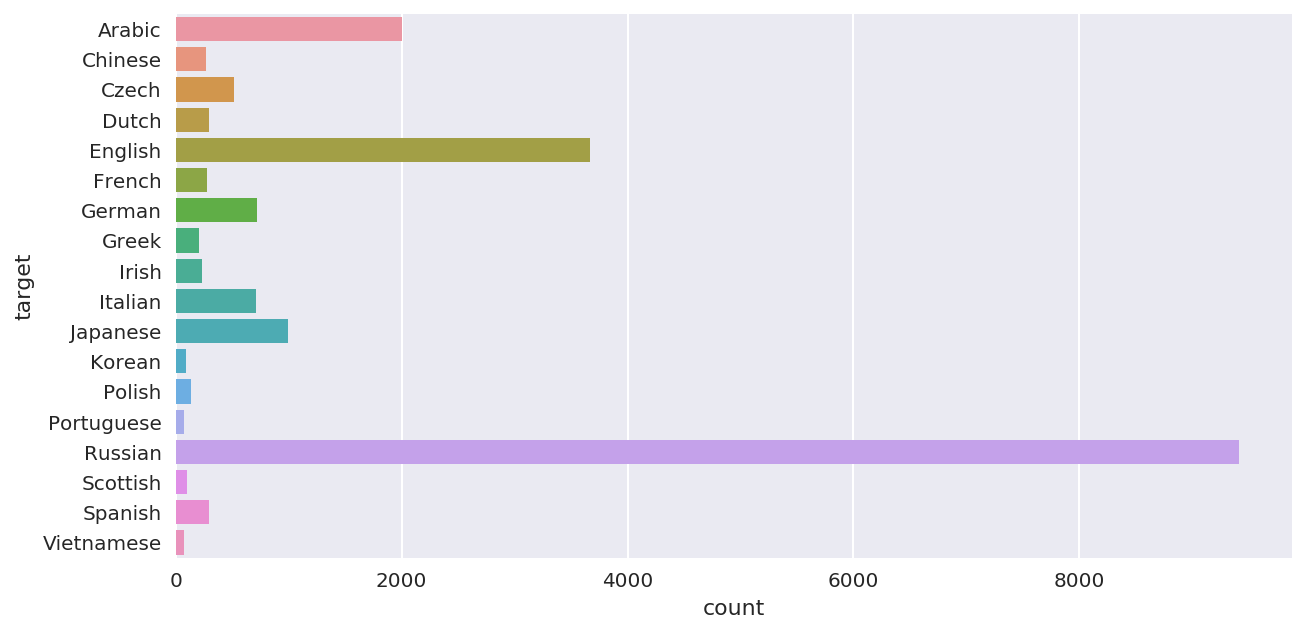

In [62]:
plt.figure(figsize=(10,5))
sns.countplot(y=df.target)

In [63]:
# cleaning data
df = df[df.word != 'ToTheFirstPage']

In [64]:
df.shape

(20050, 2)

In [65]:
df[df.word.apply(lambda x: len(x)>15)]

,word,target
3082,Vandroogenbroeck,Dutch
7689,Vongrimmelshausen,German
7785,Chrysanthopoulos,Greek
7786,Chrysanthopoulos,Greek
8048,Maceachthighearna,Irish
10239,Abdank-Kossovsky,Russian
11870,Beknazar-Yuzbashev,Russian
11873,Bekovich-Cherkassky,Russian
11991,Bestuzhev-Ryumin,Russian
13390,Gorbunov-Posadov,Russian


In [66]:
max(df.word.apply(len))

20

In [78]:
seq_len = max(df.word.apply(len))
batch_size = 32
input_size = n_letters
seq_len, input_size

(20, 56)

In [79]:
def lineToPaddedTensor(word):
    pad_len = seq_len - len(word)
    padded_word = word + '-' * pad_len
    return lineToTensor(padded_word)

In [80]:
lineToPaddedTensor(df.word[6]).shape

torch.Size([20, 1, 56])

In [81]:
hidden_size = 20 # cell size
num_layers = 2

gru = nn.GRU(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, hn = gru(input, h0)

In [83]:
idxs = np.random.choice(df.index, batch_size)
batch_words = df.word[idxs]

In [102]:
def get_batch():
    idxs = np.random.choice(df.index, batch_size)
    batch_words = df.word[idxs]
    batch_targets = df.target[idxs]
    targets_tensor = Variable(torch.LongTensor([
        [all_categories.index(target)] for target in batch_targets
    ]))
    words_tensor = Variable(torch.cat([
        lineToPaddedTensor(word) for word in batch_words
    ], dim=1))
    return batch_words, words_tensor, batch_targets, targets_tensor

In [103]:
batch_words, words_tensor, batch_targets, targets_tensor = get_batch()

In [104]:
words_tensor.shape, targets_tensor.shape

(torch.Size([20, 32, 56]), torch.Size([32, 1]))